In [101]:
import pandas as pd
import numpy as np
from numpy import newaxis
import random
import itertools
import os
import math
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.collections
from matplotlib import gridspec
from sklearn.model_selection import train_test_split
from tqdm import *

import keras
from keras.applications import *
import lightgbm as lgbm
from scipy import stats
from keras.models import Sequential, Model
from keras.layers import * #Dense, Dropout, Activation, Flatten, Input,Concatenate, concatenate
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import cv2 as cv
from os import listdir
from os.path import isfile, join
from scipy import misc
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from keras.utils.np_utils import to_categorical
from keras.callbacks import ReduceLROnPlateau

In [3]:
plt.ion()
plt.show()

In [4]:
basedir = 'data/dogs/'
files = [f for f in listdir(basedir) if isfile(join(basedir, f))]
len(files)
img_size = 240

In [5]:
def normalize(arr):
    arr=arr.astype('float32')
    if arr.max() > 1.0:
        arr/=255.0
    return arr

def resizeImg(Xg):
#     cv.normalize(Xg,  Xg, 0, 1, cv.NORM_MINMAX)
#     Xg/=255.0
    Xg = normalize(Xg)
    if Xg.shape[0] >= img_size:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_AREA)
    else:
        return cv.resize(Xg,(img_size,img_size), cv.INTER_CUBIC)

    
def readAndResize(filename):
    dog = misc.imread(basedir + filename)
    return resizeImg(dog)

(240, 240, 3)


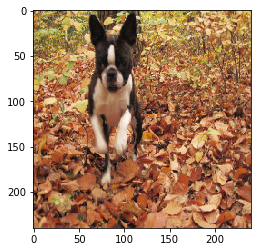

In [6]:
dog = readAndResize(files[0])
print(dog.shape)
plt.imshow(dog)
# readAndResize(files[0])

(375, 500, 3)


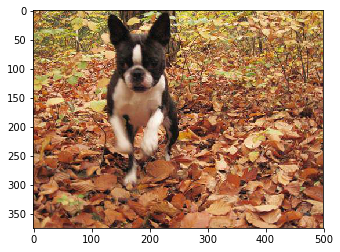

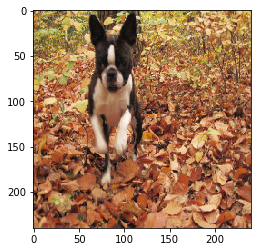

In [7]:
dog = misc.imread(basedir + files[0])
print(dog.shape)
plt.imshow(dog)
plt.show()
plt.imshow(resizeImg(dog))
plt.show()

In [8]:
def getInputImages(ids):
    data = [readAndResize(i) for i in  ids]
    data = np.stack(data)
    return data

In [130]:
from IPython.display import clear_output

class PlotLosses(keras.callbacks.Callback):
    def __init__(self):
        self.initVars()
    
    def initVars(self):
        self.i = 0
        self.x = []
        self.losses = []
        self.acc = [] #
        self.fig = plt.figure()
        self.logs = []
        self.lr = []

    def on_epoch_end(self, epoch, logs={}):     
        self.i += 1

        if self.i% 4 != 0:
            return
        
        self.losses.append(logs.get('loss'))

        self.acc.append(logs.get('acc'))
        self.logs.append(logs)
        self.x.append(self.i)
        
        clear_output(wait=True)
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        self.plotLosses(None)

        

    def plotLosses(self, ax):
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.acc, label="accuracy")

        plt.legend()
        
        
myPlot = PlotLosses()
myPlot.initVars()

## GAN

In [10]:
img_rows = img_size
img_cols = img_size
channels = 3
img_shape = (img_rows, img_cols, channels)
epochs = 100
batch_size = 20
save_interval= 10
half_batch = int(batch_size / 2)



In [114]:
def build_generator():

    noise_shape = (100,)

    model = Sequential()

    model.add(Dense(100, activation='tanh', input_shape=noise_shape))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((10, 10, 1)))
    model.add(Convolution2D(16, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((3,3)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Convolution2D(16, (3, 3), activation='relu' , padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Convolution2D(8, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    model.add(Convolution2D(3, (3, 3), activation='relu', padding='same'))
    model.add(UpSampling2D((2,2)))
    
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(512))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(1024))
#     model.add(LeakyReLU(alpha=0.2))
#     model.add(BatchNormalization(momentum=0.8))
#     model.add(Dense(np.prod(img_shape), activation='tanh'))
#     model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=noise_shape)
    img = model(noise)
    return Model(noise, img)

generator = build_generator()
# generator.compile(loss='binary_crossentropy', optimizer=Adam(0.002, 0.5))
generator.compile(loss='binary_crossentropy', optimizer='adam')


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_76 (Dense)             (None, 100)               10100     
_________________________________________________________________
leaky_re_lu_56 (LeakyReLU)   (None, 100)               0         
_________________________________________________________________
reshape_8 (Reshape)          (None, 10, 10, 1)         0         
_________________________________________________________________
conv2d_121 (Conv2D)          (None, 10, 10, 16)        160       
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 30, 30, 16)        0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 30, 30, 16)        64        
_________________________________________________________________
leaky_re_lu_57 (LeakyReLU)   (None, 30, 30, 16)        0         
__________

In [115]:

def build_discriminator():
    img_shape = (img_rows, img_cols, channels)
    input_img = Input(shape=img_shape)
    
    x = Convolution2D(16, (3, 3), activation='relu', padding='same', input_shape=img_shape)(input_img)
    x = Convolution2D(16, (3, 3), activation='relu', padding='same')(x)

    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)
    x = Convolution2D(32, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
#     x = Dropout(0.6)(x)

    x = Convolution2D(16, (3, 3),  activation='relu', padding='same')(x)
    x = MaxPooling2D(pool_size=(2,2), padding='same') (x)
    x = Dropout(0.6)(x)
    x = Flatten(input_shape=img_shape)(x)
#     x = Dense(512)(x)
#     x = LeakyReLU(alpha=0.2)(x)
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
#     x = Dense(2, activation='sigmoid')(x)
    x = Dense(2, activation='softmax')(x)


    model = Model(input_img, x)

#     model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])
#categorical_accuracy
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     model.compile(optimizer=Adam(0.0001, 0.3), loss='categorical_crossentropy', metrics=['accuracy'])
    

    model.summary()
    return model

discriminator = build_discriminator()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_50 (InputLayer)        (None, 240, 240, 3)       0         
_________________________________________________________________
conv2d_125 (Conv2D)          (None, 240, 240, 16)      448       
_________________________________________________________________
conv2d_126 (Conv2D)          (None, 240, 240, 16)      2320      
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 120, 120, 16)      0         
_________________________________________________________________
conv2d_127 (Conv2D)          (None, 120, 120, 32)      4640      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 60, 60, 32)        0         
_________________________________________________________________
conv2d_128 (Conv2D)          (None, 60, 60, 16)        4624      
__________

In [91]:
def save_imgs(epoch):

    noise = np.random.normal(0, 1, (2, 100))
    gen_imgs = generator.predict(noise)
    fig = plt.figure(figsize =(8,12))
    plt.subplot(1,2,1)
    plt.imshow(gen_imgs[0])
    plt.subplot(1,2,2)
#     gen_imgs[1] = 0.5 * gen_imgs[1] + 0.5
    plt.imshow(gen_imgs[1])
    plt.show()
    # Rescale images 0 - 1
#     gen_imgs = 0.5 * gen_imgs + 0.5
#     fig = plt.figure(figsize =())
#     fig, axs = plt.subplots(r, c)
#     cnt = 0
#     for i in range(r):
#         for j in range(c):
#             axs[i,j].imshow(gen_imgs[cnt, :,:,0])
#             axs[i,j].axis('off')
#             cnt += 1
#     plt.show()
#     fig.savefig("gan/images/mnist_%d.png" % epoch)
#     plt.close()


In [56]:
to_categorical(np.ones((2, 1)))

array([[ 0.,  1.],
       [ 0.,  1.]])

## Test discriminator

In [89]:
def getData(size):
    idx = list(np.random.randint(0, len(files), size))
    imgs = getInputImages([files[i] for i in idx])
    noise = np.random.normal(0, 1, (size, 100))
    gen_imgs = generator.predict(noise)
    d_input = np.append(imgs, gen_imgs, axis=0)

#     d_output = np.append(np.ones((size, 1), dtype=np.int), np.zeros((size, 1)), axis=0)
    d_output = np.zeros((size *2, 2))
    d_output[:size,0]= 1
    d_output[size:,1]= 1
#     print("d_output ", d_output)
    return d_input, d_output
    

In [88]:
getData(2)
1

d_output  [[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 0.  1.]]


1

In [80]:
half_batch = 2
for epoch in range(100):

    d_input, d_output = getData(half_batch)
    discriminator.fit(d_input, d_output, epochs = 1)
    pred1 = discriminator.predict(d_input)
    print('pred 1 : ', pred1, " original", np.argmax(d_output, axis=1))
    print('accuracy_score : ' , accuracy_score(np.argmax(pred1, axis=1), np.argmax(d_output, axis=1)))
    
#     t_input, t_output = getData(2)
#     pred = discriminator.predict(t_input)
#     print('pred ', pred, 'output ',t_output)
# #     pred = (discriminator.predict(t_input) > 0.5).astype(int)
# #     print('pred ', pred,  'true ', t_output)
#     max_pred = np.argmax(pred, axis=1)
#     max_output = np.argmax(t_output, axis=1)
#     print('max_pred : ', max_pred , ' max_output :', max_output)
#     print('accuracy_score : ' , accuracy_score(max_pred, max_output))


Epoch 1/1
4/4 [==============================] - 1s - loss: 0.6709 - acc: 0.5000
pred 1 :  [[ 0.80377257  0.19622745]
 [ 0.83495039  0.16504966]
 [ 0.53834569  0.46165425]
 [ 0.5378179   0.46218213]]  original [0 0 1 1]
accuracy_score :  0.5
Epoch 1/1
4/4 [==============================] - 0s - loss: 0.4780 - acc: 0.5000
pred 1 :  [[ 0.97539812  0.0246019 ]
 [ 0.970074    0.029926  ]
 [ 0.56530976  0.43469018]
 [ 0.56936705  0.43063298]]  original [0 0 1 1]
accuracy_score :  0.5
Epoch 1/1
4/4 [==============================] - 0s - loss: 0.4335 - acc: 0.5000
pred 1 :  [[ 0.98213667  0.01786334]
 [ 0.98216909  0.01783089]
 [ 0.5433116   0.45668837]
 [ 0.55430585  0.44569409]]  original [0 0 1 1]
accuracy_score :  0.5
Epoch 1/1
4/4 [==============================] - 0s - loss: 0.4100 - acc: 0.5000
pred 1 :  [[ 0.98691517  0.0130848 ]
 [ 0.98867756  0.01132241]
 [ 0.52023196  0.47976804]
 [ 0.51606739  0.48393267]]  original [0 0 1 1]
accuracy_score :  0.5
Epoch 1/1
4/4 [=================

 [  4.16938827e-04   9.99583066e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 2.5766e-04 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   9.22441623e-10]
 [  9.99990106e-01   9.89256750e-06]
 [  4.25234466e-04   9.99574721e-01]
 [  4.80223331e-04   9.99519825e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.5096e-04 - acc: 1.0000
pred 1 :  [[  9.99999881e-01   1.28870212e-07]
 [  1.00000000e+00   1.59478186e-09]
 [  3.09502590e-04   9.99690533e-01]
 [  2.35642598e-04   9.99764383e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4005e-04 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   6.72521804e-12]
 [  1.00000000e+00   2.73882765e-08]
 [  3.74225812e-04   9.99625802e-01]
 [  1.37508090e-04   9.99862432e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.

 [  3.98888951e-05   9.99960065e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 2.0847e-05 - acc: 1.0000
pred 1 :  [[  9.99999642e-01   3.30316254e-07]
 [  9.99999762e-01   2.09780680e-07]
 [  4.12920999e-05   9.99958754e-01]
 [  3.56419368e-05   9.99964356e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.4276e-05 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   6.57329524e-10]
 [  9.99999285e-01   7.47045135e-07]
 [  2.29904963e-05   9.99976993e-01]
 [  2.97465212e-05   9.99970198e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.5214e-05 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   4.92843211e-10]
 [  1.00000000e+00   2.69466532e-11]
 [  3.87964683e-05   9.99961257e-01]
 [  1.82327749e-05   9.99981761e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.

 [  4.49159961e-05   9.99955058e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 2.3157e-05 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   3.05991868e-24]
 [  1.00000000e+00   1.93019287e-29]
 [  3.90888090e-05   9.99960899e-01]
 [  5.05563657e-05   9.99949455e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 1.8031e-05 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   4.30501057e-19]
 [  1.00000000e+00   1.13925394e-25]
 [  3.40068800e-05   9.99966025e-01]
 [  3.60340055e-05   9.99963999e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 2.9610e-05 - acc: 1.0000
pred 1 :  [[  1.00000000e+00   8.26988446e-24]
 [  1.00000000e+00   5.51442109e-23]
 [  4.07978223e-05   9.99959230e-01]
 [  7.42913689e-05   9.99925733e-01]]  original [0 0 1 1]
accuracy_score :  1.0
Epoch 1/1
4/4 [==============================] - 0s - loss: 2.

In [131]:
epochs = 20000
batch_size = 30
save_interval= 2
half_batch = int(batch_size / 2)

z = Input(shape=(100,))
img = generator(z)
discriminator.trainable = False
valid = discriminator(img)
combined = Model(z, valid)
# combined.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
combined.compile(loss='binary_crossentropy', optimizer='nadam')

for epoch in range(epochs):
    d_input, d_output = getData(half_batch)
    discriminator.trainable = True
    reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.6,
              patience=30, min_lr=0.001)

    h = discriminator.fit(d_input, d_output, epochs = 1, verbose=0, callbacks=[reduce_lr, myPlot])
    print('history : ', h.history)
    
    #Prediction
#     t_input, t_output = getData(2)
#     pred = (discriminator.predict(t_input) > 0.5).astype(int)
#     print(accuracy_score(pred, t_output))
    discriminator.trainable = False


#     discriminator.trainable = True
#     discriminator.train_on_batch(d_input, d_output)

    # ---------------------
    #  Train Generator
    # ---------------------

    noise = np.random.normal(0, 1, (batch_size, 100))

    # The generator wants the discriminator to label the generated samples
    # as valid (ones)
#     valid_y = np.array([1] * batch_size)

    valid_y = np.zeros((batch_size, 2))
    valid_y[:,0]= 1
    
    # Train the generator
    g_loss = combined.train_on_batch(noise, valid_y)
    print('g_loss : ', g_loss)
    
    if epoch % save_interval == 0:
        save_imgs(epoch)

history :  {'loss': [0.69335740804672241], 'acc': [0.5], 'lr': [0.001]}
g_loss :  0.713223
history :  {'loss': [0.6966291069984436], 'acc': [0.5], 'lr': [0.001]}
g_loss :  0.712599


KeyboardInterrupt: 